## Amsterdam best Restaurant location

### This is the Notebook for the week 2 scope Capstone project. 

* A **link** to the notebook viewer *showing maps* as well is included in the **README.md** file and as well below:

* https://nbviewer.jupyter.org/github/sgatea/Coursera-Capstone---The-Battle-of-Neighborhoods/blob/master/Amsterdam%20best%20Restaurant%20location-SG.ipynb


### Business Problem

We have been tasked to evaluate a good location for a restaurant, as described in Week 1 Intorduction by the imaginary IFDR (International Flying Dutch Restaurants) company. The final report audience will be the top management of IFDR, and will be summarized based on the conclusions drawn after we use the code below and additional information available about Amsterdam city.

In Amsterdam the mix / variety of restaurants is impressive as it is a multicultural and open city which is valued by the community of expats working in The Netherlands. We are interested to find a location best suited for opening a new Restaurant which has as main characteristic High Standard international cuisine, therefore not based on specific country cuisine tradition.

We will look into locations that have less density and variety of Restaurants and are well populated, although if the restaurant is of very good quality it is typical that a lot pf people from other locations will travel to our location.

As for Supply Chain with daily fresh products for our restaurant, in Amsterdam area there are absolutely no concerns since the number of suppliers and the variety of fresh products is very large.

A summary report for IFDR stakeholders, and a blog-post sample will be issued based on the findings.

### Data used for the analysis

The data used in the project will be mainly open data sources from data.amsterdam.nl, in combination with the data that can be retrieved using the Foursquare API and consolidate venues of Restaurant type per Amsterdam boroughs. Key criteria:
1. Boroughs density of Restaurants 
2. Demographics (population density per borough)

Note we excluded metrics such as "distance from centre" since Amsterdam is a small city with excellent public transport facilities and as well dedicated cycling paths.

#### Import libraries

In [1]:
import requests
import wget
import geocoder
import math
import folium
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.cm as cm  # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans # KMeans for clustering
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import json
import seaborn as sns
sns.set_style('darkgrid')

#### Read required tables using pandas read_html() method to retrieve Borughs, Population and Neighborhood data

In [2]:
url = 'https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam'

#### Next steps:
1. Retrieve Boroughs / Neighborhoods data and perform the the exeploratory analysis and take further steps to prepare the data set required for the analysis
2. Use Fouraquare API to retriueve venue information based on the location centroids we decided to use
3. Display map data using Folium.
4. Analyze restaurant density per area based on Foursquare API information and as well the Amsterdam open data sets available for download.
5. Perfrom clustering of restaurant data
6. Analyze final data set containing loxcation, population density

#### Boroughs data

In [4]:
table = pd.read_html(url)

# Boroughs
print(table[1])  # index 1 returns the 2nd table from the web page

                   Borough       Area  Population Population density  \
0         Centrum (Centre)   8.04 km²       86422         13,748/km²   
1            Noord (North)  49.01 km²       94766          2,269/km²   
2     Nieuw-West(New West)  32.38 km²      151677          4,478/km²   
3              Oost (East)  30.56 km²      135767          7,635/km²   
4                     West   9.89 km²      143842         15,252/km²   
5  Westpoort(West Gateway)     10 km²         192             10/km²   
6             Zuid (South)  17.41 km²      144432          9,349/km²   
7      Zuidoost(Southeast)  22.08 km²       87854          4,391/km²   

   Location (in green)  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  


In [5]:
# Create Borough data frame - bor_df
bor_df = pd.DataFrame(table[1])
print(bor_df)

                   Borough       Area  Population Population density  \
0         Centrum (Centre)   8.04 km²       86422         13,748/km²   
1            Noord (North)  49.01 km²       94766          2,269/km²   
2     Nieuw-West(New West)  32.38 km²      151677          4,478/km²   
3              Oost (East)  30.56 km²      135767          7,635/km²   
4                     West   9.89 km²      143842         15,252/km²   
5  Westpoort(West Gateway)     10 km²         192             10/km²   
6             Zuid (South)  17.41 km²      144432          9,349/km²   
7      Zuidoost(Southeast)  22.08 km²       87854          4,391/km²   

   Location (in green)  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6                  NaN  
7                  NaN  


In [6]:
# Dropping unnecessary columns, we keep only Boroughs and Population
bor_df = bor_df.drop(['Area', 'Population density', 'Location (in green)'],1)
bor_df.replace({'Centrum (Centre)':'Centrum', 'Noord (North)':'Noord', 'Nieuw-West(New West)':'Nieuw-West',
                    'Oost (East)':'Oost', 'Westpoort(West Gateway)':'Westpoort', 'Zuid (South)':'Zuid', 
                    'Zuidoost(Southeast)':'Zuidoost'}, inplace=True)

print(bor_df)
bor_df.to_csv('Boroughs.csv')

      Borough  Population
0     Centrum       86422
1       Noord       94766
2  Nieuw-West      151677
3        Oost      135767
4        West      143842
5   Westpoort         192
6        Zuid      144432
7    Zuidoost       87854


#### Neighborhoods data

In [7]:
# Neighborhoods
print(table[3])  # index 3 returns the 4th table from the web page

                      vteNeighbourhoods of Amsterdam  \
0                                            Centrum   
1                                         Nieuw-West   
2                                              Noord   
3                                               Oost   
4                                               West   
5                                               Zuid   
6                                           Zuidoost   
7                                          Westpoort   
8  Former boroughs: De Baarsjes - Geuzenveld-Slot...   

                    vteNeighbourhoods of Amsterdam.1  \
0  Binnenstad (Oude Zijde - Nieuwe Zijde) Grachte...   
1  Geuzenveld (De Eendracht) Nieuw Sloten Oostoev...   
2  Banne Buiksloot Buiksloot Buikslotermeer Flora...   
3  IJburg (Haveneiland - Rieteilanden - Steigerei...   
4  Admiralenbuurt Bos en Lommer (Kolenkitbuurt - ...   
5  Apollobuurt Buitenveldert Hoofddorppleinbuurt ...   
6  Bijlmer Bullewijk Driemond Gaasperdam Holend

In [8]:
# Create Neighborhood data frame - ne_df
ne_df = pd.DataFrame(table[3])
print(ne_df)

                      vteNeighbourhoods of Amsterdam  \
0                                            Centrum   
1                                         Nieuw-West   
2                                              Noord   
3                                               Oost   
4                                               West   
5                                               Zuid   
6                                           Zuidoost   
7                                          Westpoort   
8  Former boroughs: De Baarsjes - Geuzenveld-Slot...   

                    vteNeighbourhoods of Amsterdam.1  \
0  Binnenstad (Oude Zijde - Nieuwe Zijde) Grachte...   
1  Geuzenveld (De Eendracht) Nieuw Sloten Oostoev...   
2  Banne Buiksloot Buiksloot Buikslotermeer Flora...   
3  IJburg (Haveneiland - Rieteilanden - Steigerei...   
4  Admiralenbuurt Bos en Lommer (Kolenkitbuurt - ...   
5  Apollobuurt Buitenveldert Hoofddorppleinbuurt ...   
6  Bijlmer Bullewijk Driemond Gaasperdam Holend

In [9]:
# Dropping unnecessary rows & columns and rename
ne_df = ne_df.drop(['vteNeighbourhoods of Amsterdam.2'],1)
ne_df = ne_df.drop(ne_df.index[8])
ne_df.rename(columns={'vteNeighbourhoods of Amsterdam.1':'Neighborhood',
                      'vteNeighbourhoods of Amsterdam':'Borough'}, inplace=True)

ne_df.to_csv('Neighborhoods.csv')
ne_df.head(10)

,Borough,Neighborhood
0,Centrum,Binnenstad (Oude Zijde - Nieuwe Zijde) Grachte...
1,Nieuw-West,Geuzenveld (De Eendracht) Nieuw Sloten Oostoev...
2,Noord,Banne Buiksloot Buiksloot Buikslotermeer Flora...
3,Oost,IJburg (Haveneiland - Rieteilanden - Steigerei...
4,West,Admiralenbuurt Bos en Lommer (Kolenkitbuurt - ...
5,Zuid,Apollobuurt Buitenveldert Hoofddorppleinbuurt ...
6,Zuidoost,Bijlmer Bullewijk Driemond Gaasperdam Holendre...
7,Westpoort,Teleport Westelijk Havengebied (Ruigoord)


#### Merging Boroughs and Neighborhoods data in a new dataframe "ams_df"

In [10]:
# Merging the Borough and Neighborhood tables on "Borough" as new ams_df table containing Boroughs, Neighborhood and Population
ams_df = pd.merge(bor_df, ne_df, on='Borough')

In [11]:
print(ams_df)
ams_df.to_csv('amsterdam_loc.csv', index=False)

      Borough  Population                                       Neighborhood
0     Centrum       86422  Binnenstad (Oude Zijde - Nieuwe Zijde) Grachte...
1       Noord       94766  Banne Buiksloot Buiksloot Buikslotermeer Flora...
2  Nieuw-West      151677  Geuzenveld (De Eendracht) Nieuw Sloten Oostoev...
3        Oost      135767  IJburg (Haveneiland - Rieteilanden - Steigerei...
4        West      143842  Admiralenbuurt Bos en Lommer (Kolenkitbuurt - ...
5   Westpoort         192          Teleport Westelijk Havengebied (Ruigoord)
6        Zuid      144432  Apollobuurt Buitenveldert Hoofddorppleinbuurt ...
7    Zuidoost       87854  Bijlmer Bullewijk Driemond Gaasperdam Holendre...


#### Decisions after inspecting the data: 
* As Amsterdam is a small city we notice that a segmentation based on Neighborhood does not add extra value to the analysis, so we keep Boroughs as baseline, adding the geo-coordinates
* We will also drop Westport borough as this is the port and industrial area of Amsterdam (only 192 persons are living there)

In [12]:
# Drop neighborhood from ams_df
ams_df = ams_df.drop(['Neighborhood'], 1)
ams_df = ams_df.drop(ams_df.index[5])  # removing row index 5

In [13]:
# Loading data downloaded from data.asmterdam.nl with geo-coordinates in new amsgeo_df
amsgeo_df = pd.read_csv('ams_locations_nn.csv')

In [14]:
# Compiling final "amsdata_df" holding Borough, Pupulation and Geo-Coordinates information
amsdata_df = pd.merge(ams_df, amsgeo_df, on='Borough')

#### Display and save 'amsdata_df' that contains our relevant baseline information using Borough segmentation and geo-coordinates

In [15]:
# Display and save "amsdata_df"
amsdata_df.to_csv('amsdata_df.csv', index=False)
amsdata_df

,Borough,Population,Latitude,Longitude
0,Centrum,86422,52.369985,4.898014
1,Noord,94766,52.391111,4.918306
2,Nieuw-West,151677,52.363742,4.806862
3,Oost,135767,52.352778,4.930556
4,West,143842,52.383025,4.852867
5,Zuid,144432,52.346389,4.858611
6,Zuidoost,87854,52.310556,4.973333


### Foursquare data and map vizualization

#### Foursquare credentials

In [16]:
# @hidden_cell
CLIENT_ID = 'XXXX' # Foursquare ID
CLIENT_SECRET = 'YYYY' # Foursquare Secret
VERSION = '20180604'
LIMIT = 30

#### Use Nominatim to retrieve Amsterdam geo-coordinates

In [18]:
address = 'Amsterdam, NL'

geolocator = Nominatim(user_agent="Foursquare_agent")
location = geolocator.geocode(address)
ams_latitude = location.latitude
ams_longitude = location.longitude
print('Amsterdam Geographical coordinates are Lat={}, Lng={} '.format(ams_latitude, ams_longitude))

Amsterdam Geographical coordinates are Lat=52.3727598, Lng=4.8936041 


In [19]:
amsterdam_map = folium.Map(location=[ams_latitude, ams_longitude], zoom_start=11, control_scale = True)

# Toronto map markers (tag's)
for lat, lng, Borough in zip(amsdata_df['Latitude'], amsdata_df['Longitude'], amsdata_df['Borough']):
    tag = '{}'.format(Borough)
    tag = folium.Popup(tag, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=tag,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_map)

# adding a folium feature allowing location [Neighborhood, Borough], and coordinates shown with mouse-over and 
# mouse click on the map 
amsterdam_map.add_child(folium.LatLngPopup())
    
amsterdam_map

#### We define a function that can be used to retrieve venues based on the location (Neighbourhood), and geo-ccordinates passed from the toronto_df 
* The function will collect first the venues info using the Foursquare explore API, add them to a venues_list, and then process the list in a venue_df.
* We added the Foursquare argument <code>query = 'Restaurant'</code> to filter the relevant venues with Restaurant profile

In [20]:
def getNearbyVenues (names, latitude, longitude, radius=2000, limit=100, query='Restaurant'):
    
    venue_lst=[] # initialize empty list
    
    for name, lat, lng in zip (names, latitude, longitude):
        print(name)
        
    
        # Foursuare API explore generated per Neighbourhood lat / lng passed from toronto_df
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            query)
        
        # Get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
                
        # return only relevant information for each nearby venue in the preliminary list
        venue_lst.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    venue_df = pd.DataFrame([item for venue_lst in venue_lst for item in venue_lst])
    venue_df.columns = ['Borough', 
                  'Borough Lat', 
                  'Borough Lng', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Lng', 
                  'Venue Category']

    print('{} venues were returned by Foursquare.'.format(venue_df.shape[0]))
    
    return (venue_df)


#### Retieving venues relevant info in a new 'amsterdam_venues_df' dataframe calling the 'getNearbyVenues' function
* We are passing the Borough + Geo-location data from the 'amsdata_df' dataframe to 'getNearbyVenues' function.
* getNearbyVenues will append the information in a list "venue_lst" that will be finally stored in "venue_df" dataframe

In [21]:
amsterdam_venues_df = getNearbyVenues (names=amsdata_df['Borough'], 
                                     latitude=amsdata_df['Latitude'], 
                                     longitude=amsdata_df['Longitude'])

Centrum
Noord
Nieuw-West
Oost
West
Zuid
Zuidoost
624 venues were returned by Foursquare.


###  Overview of the 'amsterdam_venues_df' with the Venue Category containing mix types of food serving locations
* We have identified 624 locations that serve food (Restaurants or other types)

In [22]:
# checking amsterdam_venues dataframe size and summary content
print(amsterdam_venues_df.shape)
amsterdam_venues_df.head(10)

(624, 7)


,Borough,Borough Lat,Borough Lng,Venue,Venue Lat,Venue Lng,Venue Category
0,Centrum,52.369985,4.898014,The Lobby,52.371159,4.893661,Restaurant
1,Centrum,52.369985,4.898014,"""Krua Thai"" Classic",52.368207,4.898012,Thai Restaurant
2,Centrum,52.369985,4.898014,Puccini Espressobar,52.368126,4.898638,Italian Restaurant
3,Centrum,52.369985,4.898014,De Laatste Kruimel,52.369220,4.892810,Bakery
4,Centrum,52.369985,4.898014,Cafe Droog,52.368375,4.897672,Café
5,Centrum,52.369985,4.898014,Café van Kerkwijk,52.371494,4.893658,Restaurant
6,Centrum,52.369985,4.898014,Gartine,52.369157,4.891615,Breakfast Spot
7,Centrum,52.369985,4.898014,Bridges Restaurant,52.370818,4.895087,Seafood Restaurant
8,Centrum,52.369985,4.898014,Bagels & Beans,52.368850,4.900435,Bagel Shop
9,Centrum,52.369985,4.898014,Sterk Staaltje,52.368314,4.897048,Deli / Bodega


In [23]:
# Optional: Saving amsterdam_venues_df
amsterdam_venues_df.to_csv('amsterdam_venues.csv', index=False)

In [24]:
print('There are {} uniques food serving categories.'.format(len(amsterdam_venues_df['Venue Category'].unique())))

There are 75 uniques food serving categories.


#### Visualizing the 'Venue Category' using sns.counplot for all data in amsterdam_venues_df

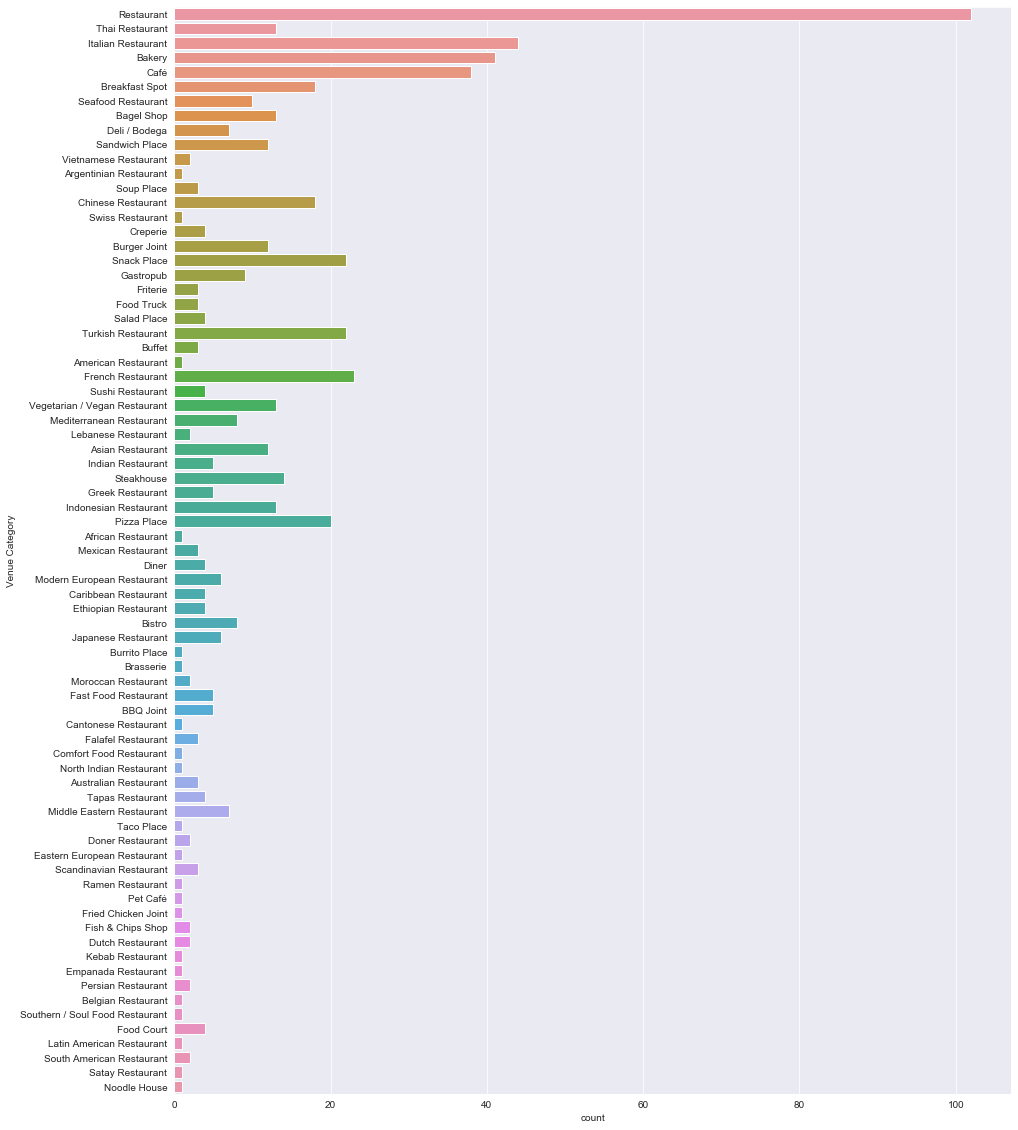

In [25]:
# Class distributions for 'Venue Category'

plt.figure(figsize=(15,20))
sns.countplot (y='Venue Category', data=amsterdam_venues_df)

plt.show()

#### We check how many venues of were returned for each Borough in "amsterdam_venues_df"

In [26]:
amsterdam_venues_df.groupby('Borough').count()

,Borough Lat,Borough Lng,Venue,Venue Lat,Venue Lng,Venue Category
Borough,,,,,,
Centrum,100,100,100,100,100,100
Nieuw-West,60,60,60,60,60,60
Noord,88,88,88,88,88,88
Oost,100,100,100,100,100,100
West,100,100,100,100,100,100
Zuid,100,100,100,100,100,100
Zuidoost,76,76,76,76,76,76


#### We can  inspect as well amsterdam_venues_df by the 'Venue Category' and 'Borough' to get an overview of the mix of restaurant venues types per Borough

In [27]:
# groupby 'Borough' and 'Venue Category' .size()
amsterdam_venues_df.groupby(['Borough','Venue Category']).size()

Borough     Venue Category                 
Centrum     African Restaurant                  1
            American Restaurant                 1
            Argentinian Restaurant              1
            Asian Restaurant                    1
            Bagel Shop                          2
            Bakery                              4
            Breakfast Spot                      6
            Buffet                              1
            Burger Joint                        5
            Café                                8
            Chinese Restaurant                  2
            Creperie                            3
            Deli / Bodega                       2
            Food Truck                          1
            French Restaurant                   8
            Friterie                            1
            Gastropub                           2
            Greek Restaurant                    1
            Indian Restaurant                   1
      

### We can as well filter and retain only the venues that are Restaurants in the 'Venue Category' in a new dataframe
* It is noticeable that the number of 'Venue Categories' has decreased since now we have only objects of Rastaurant type

In [28]:
amsterdam_rest_df = amsterdam_venues_df[amsterdam_venues_df['Venue Category'].str.contains('Restaurant')]


#### The new 'amsterdam_rest_df' has less objects (371) than the priginal 'amsterdam_venues_df' (624), since we filtered the Venue Category to retain only venues that are of Restaurant types

In [29]:
# checking amsterdam_rest dataframe size and summary content
print(amsterdam_rest_df.shape)
amsterdam_rest_df.head(10)

(369, 7)


,Borough,Borough Lat,Borough Lng,Venue,Venue Lat,Venue Lng,Venue Category
0,Centrum,52.369985,4.898014,The Lobby,52.371159,4.893661,Restaurant
1,Centrum,52.369985,4.898014,"""Krua Thai"" Classic",52.368207,4.898012,Thai Restaurant
2,Centrum,52.369985,4.898014,Puccini Espressobar,52.368126,4.898638,Italian Restaurant
5,Centrum,52.369985,4.898014,Café van Kerkwijk,52.371494,4.893658,Restaurant
7,Centrum,52.369985,4.898014,Bridges Restaurant,52.370818,4.895087,Seafood Restaurant
11,Centrum,52.369985,4.898014,Pho King,52.366789,4.894902,Vietnamese Restaurant
12,Centrum,52.369985,4.898014,CAU,52.372368,4.894503,Argentinian Restaurant
13,Centrum,52.369985,4.898014,Eatmosfera,52.366115,4.895121,Italian Restaurant
15,Centrum,52.369985,4.898014,The Seafood Bar,52.368730,4.890600,Seafood Restaurant
16,Centrum,52.369985,4.898014,Bhatti Pasal,52.368055,4.890838,Restaurant


In [30]:
# Optional: Saving amsterdam_rest_df
amsterdam_rest_df.to_csv('amsterdam_rest.csv', index=False)

#### Displaying a map of the Restaurants distributed on Amsterdam map overlay

In [31]:
amsterdam_rest_map = folium.Map(location=[ams_latitude, ams_longitude], zoom_start=12, control_scale = True)

# Toronto map markers (tag's)
for lat, lng, Borough, venue in zip(amsterdam_rest_df['Venue Lat'], amsterdam_rest_df['Venue Lng'], amsterdam_rest_df['Borough'], amsterdam_rest_df['Venue']):
    tag = '{}'.format(Borough)
    tag = folium.Popup(tag, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=tag,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(amsterdam_rest_map)

# adding a folium feature allowing location, and coordinates shown with mouse-over and 
# mouse click on the map 
amsterdam_rest_map.add_child(folium.LatLngPopup())
    
amsterdam_rest_map

In [32]:
amsterdam_rest_df.groupby('Borough').count()

,Borough Lat,Borough Lng,Venue,Venue Lat,Venue Lng,Venue Category
Borough,,,,,,
Centrum,49,49,49,49,49,49
Nieuw-West,33,33,33,33,33,33
Noord,45,45,45,45,45,45
Oost,71,71,71,71,71,71
West,67,67,67,67,67,67
Zuid,59,59,59,59,59,59
Zuidoost,45,45,45,45,45,45


#### Visualization of Restaurant distribution per Borough

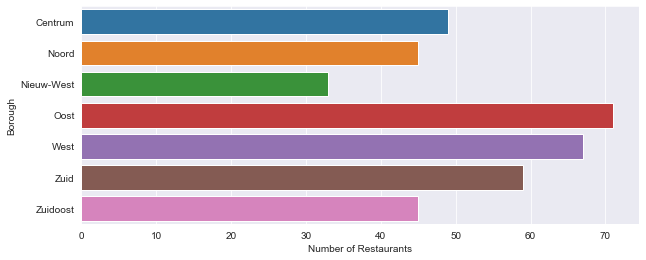

In [33]:
# Class distributions for Borough and Number of Restaurants
plt.figure(figsize=(10,4))
sns.countplot (y='Borough', data=amsterdam_rest_df)
plt.xlabel('Number of Restaurants')

plt.show()

#### Visualizing the 'Venue Category' Restaurant type using sns.counplot for Nieuw-West borough on 'amsterdam_rest_df'

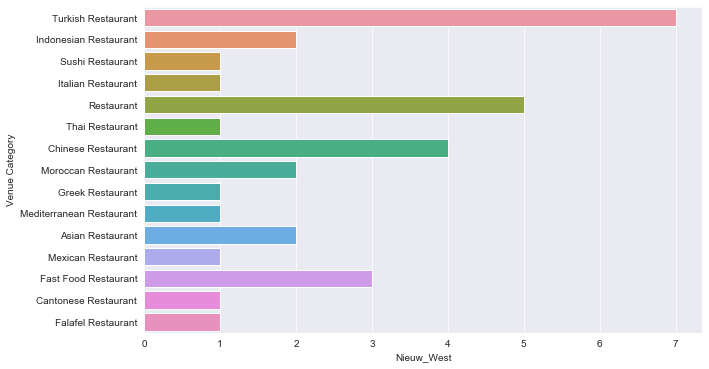

In [37]:
# Overall Class distribution for 'Venue Category' for Nieuw-West Borough

plt.figure(figsize=(10,6))
sns.countplot (y='Venue Category', data=amsterdam_rest_df[amsterdam_rest_df['Borough'].str.contains('Nieuw-West')])
plt.xlabel('Nieuw_West')
plt.show()

#### Visualizing the 'Venue Category' Restaurants using sns.counplot on all 'amsterdam_rest_df'

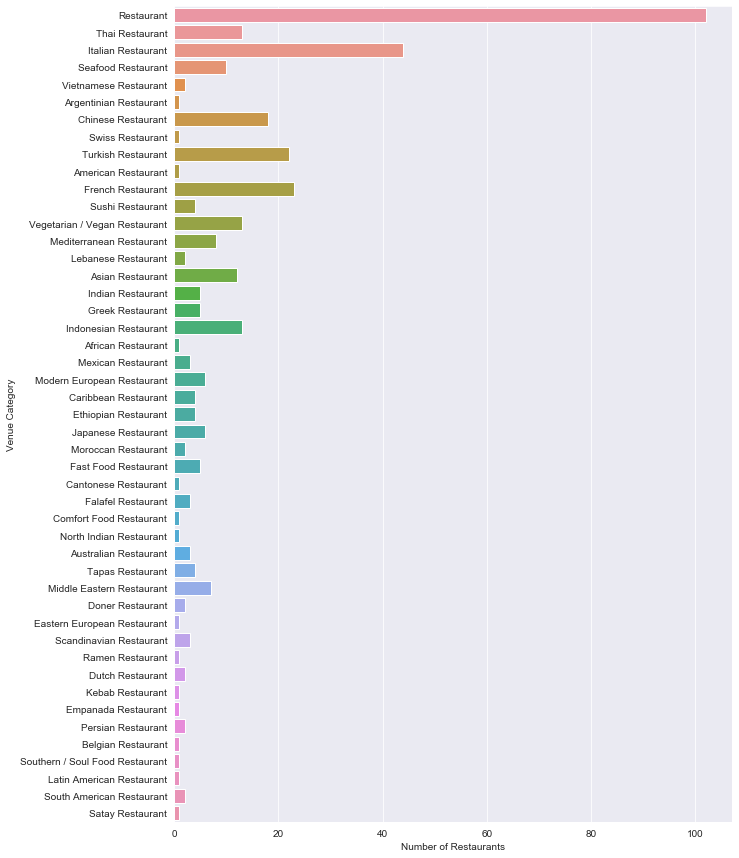

In [36]:
# Overall Class distribution for 'Venue Category' in all amsterdam_rest_df dataset
plt.figure(figsize=(10,15))
sns.countplot (y='Venue Category', data=amsterdam_rest_df)
plt.xlabel('Number of Restaurants')
plt.show()

#### We can  inspect as well amsterdam_venues_df by the 'Venue Category' and 'Borough' again to get an overview of only restaurant objects per Borough
* We notice the numbers diminished substantially as we retain only the Restaurants on the 'Venue Category'

In [38]:
# groupby 'Borough' and 'Venue Category' .size()
amsterdam_rest_df.groupby(['Borough','Venue Category']).size()

Borough     Venue Category                 
Centrum     African Restaurant                  1
            American Restaurant                 1
            Argentinian Restaurant              1
            Asian Restaurant                    1
            Chinese Restaurant                  2
            French Restaurant                   8
            Greek Restaurant                    1
            Indian Restaurant                   1
            Indonesian Restaurant               1
            Italian Restaurant                  6
            Lebanese Restaurant                 2
            Mediterranean Restaurant            3
            Restaurant                         10
            Seafood Restaurant                  2
            Sushi Restaurant                    1
            Swiss Restaurant                    1
            Thai Restaurant                     4
            Turkish Restaurant                  1
            Vegetarian / Vegan Restaurant       1
      

#### We notice we dropped from 75 unique categories to 47 unique categories in 'Venue Category'. All of the 47 are actually Restaurant types

In [39]:
print('There are {} uniques Restarant categories.'.format(len(amsterdam_rest_df['Venue Category'].unique())))

There are 47 uniques Restarant categories.


### Encoding Venues in 'amsterdam_rest_df' and preparing for analysis

In [40]:
# one hot encoding of the Venue Category
amsterdam_onehot = pd.get_dummies(amsterdam_rest_df[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
amsterdam_onehot['Borough'] = amsterdam_rest_df['Borough'] 

# move borough column to the first column
fixed_columns = [amsterdam_onehot.columns[-1]] + list(amsterdam_onehot.columns[:-1])
amsterdam_onehot = amsterdam_onehot[fixed_columns]

amsterdam_onehot.head()

,Borough,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,North Indian Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [41]:
# Number of venues encoded
print('{} venues encoded.'.format(amsterdam_onehot.shape[0]-1))
# Shape of encoded dataframe
print('Shape amsterdam_onehot:', amsterdam_onehot.shape)

368 venues encoded.
Shape amsterdam_onehot: (369, 48)


In [42]:
# Optional - save the encoded df
amsterdam_onehot.to_csv('amsterdam_onehot.csv', index=False)

#### We group rows by neighborhood and taking the mean of the frequency of occurrence of each category

In [43]:
amsterdam_grouped = amsterdam_onehot.groupby('Borough').mean().reset_index()

# Display the grouped dataframe
amsterdam_grouped

,Borough,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,North Indian Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Centrum,0.020408,0.020408,0.020408,0.020408,0.000000,0.000000,0.000000,0.000000,0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163265,0.020408,0.020408,0.020408,0.122449,0.000000,0.000000,0.000000,0.040816,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204082,0.000000,0.000000,0.040816,0.000000,0.000000,0.020408,0.020408,0.000000,0.081633,0.020408,0.020408,0.020408
1,Nieuw-West,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,0.030303,0.000000,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.090909,0.000000,0.030303,0.000000,0.060606,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.030303,0.212121,0.000000,0.000000
2,Noord,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.022222,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000,0.044444,0.066667,0.044444,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667,0.022222,0.022222
3,Oost,0.000000,0.000000,0.000000,0.028169,0.028169,0.000000,0.000000,0.014085,0.000000,0.014085,0.014085,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.126761,0.000000,0.028169,0.042254,0.183099,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.042254,0.042254,0.000000,0.014085,0.000000,0.000000,0.211268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.042254,0.056338,0.070423,0.000000
4,West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029851,0.014925,0.000000,0.000000,0.029851,0.000000,0.014925,0.000000,0.014925,0.014925,0.014925,0.029851,0.000000,0.044776,0.149254,0.014925,0.014925,0.000000,0.000000,0.044776,0.014925,0.029851,0.014925,0.000000,0.000000,0.029851,0.014925,0.268657,0.000000,0.014925,0.029851,0.000000,0.000000,0.000000,0.000000,0.014925,0.029851,0.059701,0.044776,0.000000
5,Zuid,0.000000,0.000000,0.000000,0.016949,0.016949,0.016949,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.000000,0.050847,0.000000,0.000000,0.067797,0.016949,0.016949,0.033898,0.118644,0.033898,0.000000,0.016949,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.389831,0.000000,0.000000,0.033898,0.000000,0.016949,0.016949,0.000000,0.033898,0.016949,0.000000,0.033898,0.000000
6,Zuidoost,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000,0.000000,0.022222,0.000000,0.088889,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.288889,0.022222,0.044444,0.044444,0.044444,0.000000,0.022222,0.000000,0.000000,0.022222,0.066667,0.022222,0.00000

### Borough / Restaurant mean frequency (sum) 
* Note **Nieuw-West** lower on Restaurant type (only) than other boroughs

In [44]:
amsterdam_grouped.groupby(['Borough','Restaurant']).sum()

,,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,North Indian Restaurant,Persian Restaurant,Ramen Restaurant,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Borough,Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Centrum,0.204082,0.020408,0.020408,0.020408,0.020408,0.000000,0.000000,0.000000,0.000000,0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163265,0.020408,0.020408,0.020408,0.122449,0.000000,0.000000,0.000000,0.040816,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040816,0.000000,0.000000,0.020408,0.020408,0.000000,0.081633,0.020408,0.020408,0.020408
Nieuw-West,0.151515,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,0.030303,0.000000,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.090909,0.000000,0.030303,0.000000,0.060606,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.030303,0.212121,0.000000,0.000000
Noord,0.400000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.022222,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000,0.044444,0.066667,0.044444,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667,0.022222,0.022222
Oost,0.211268,0.000000,0.000000,0.000000,0.028169,0.028169,0.000000,0.000000,0.014085,0.000000,0.014085,0.014085,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.126761,0.000000,0.028169,0.042254,0.183099,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.042254,0.042254,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.042254,0.056338,0.070423,0.000000
West,0.268657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029851,0.014925,0.000000,0.000000,0.029851,0.000000,0.014925,0.000000,0.014925,0.014925,0.014925,0.029851,0.000000,0.044776,0.149254,0.014925,0.014925,0.000000,0.000000,0.044776,0.014925,0.029851,0.014925,0.000000,0.000000,0.029851,0.014925,0.000000,0.014925,0.029851,0.000000,0.000000,0.000000,0.000000,0.014925,0.029851,0.059701,0.044776,0.000000
Zuid,0.389831,0.000000,0.000000,0.000000,0.016949,0.016949,0.016949,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.000000,0.050847,0.000000,0.000000,0.067797,0.016949,0.016949,0.033898,0.118644,0.033898,0.000000,0.016949,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033898,0.000000,0.016949,0.016949,0.000000,0.033898,0.016949,0.000000,0.033898,0.000000
Zuidoost,0.288889,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000,0.000000,0.022222,0.000000,0.088889,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.044444,0.044444,0.044444,0.000000,0.022222,0.000000,0.000000,0

In [45]:
amsterdam_grouped.shape

(7, 48)

In [46]:
# Optional - save amsterdam_grouped dataframe
amsterdam_grouped.to_csv('amsterdam_grouped.csv', index=False)

#### Let's print each Borough along with the top 10 most common food location venues

In [47]:
num_top_venues = 10

for place in amsterdam_grouped['Borough']:
    print("----"+place+"----")
    temp = amsterdam_grouped[amsterdam_grouped['Borough'] == place].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    # print(temp)
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Centrum----
                      venue  freq
0                Restaurant  0.20
1         French Restaurant  0.16
2        Italian Restaurant  0.12
3           Thai Restaurant  0.08
4  Mediterranean Restaurant  0.06
5        Chinese Restaurant  0.04
6       Lebanese Restaurant  0.04
7        Seafood Restaurant  0.04
8         Indian Restaurant  0.02
9     Indonesian Restaurant  0.02


----Nieuw-West----
                   venue  freq
0     Turkish Restaurant  0.21
1             Restaurant  0.15
2     Chinese Restaurant  0.12
3   Fast Food Restaurant  0.09
4       Asian Restaurant  0.06
5  Indonesian Restaurant  0.06
6    Moroccan Restaurant  0.06
7       Sushi Restaurant  0.03
8     Falafel Restaurant  0.03
9     Italian Restaurant  0.03


----Noord----
                        venue  freq
0                  Restaurant  0.40
1            Asian Restaurant  0.07
2          Turkish Restaurant  0.07
3          Italian Restaurant  0.07
4          Chinese Restaurant  0.07
5          Seafo

#### We store this information in a new pandas dataframe
* We first write a function to sort the venues in descending order.

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating the new dataframe 'boroughs_venues_sorted' and display the top 10 venues for each borough.
* This is based on amsterdam_rest_df dataframe containing Restautant type only information 

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = amsterdam_grouped['Borough']

for ind in np.arange(amsterdam_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centrum,Restaurant,French Restaurant,Italian Restaurant,Thai Restaurant,Mediterranean Restaurant,Chinese Restaurant,Seafood Restaurant,Lebanese Restaurant,Vietnamese Restaurant,American Restaurant
1,Nieuw-West,Turkish Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Moroccan Restaurant,Indonesian Restaurant,Asian Restaurant,Falafel Restaurant,Cantonese Restaurant,Greek Restaurant
2,Noord,Restaurant,Turkish Restaurant,Chinese Restaurant,Italian Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,Modern European Restaurant,Indonesian Restaurant,Vegetarian / Vegan Restaurant
3,Oost,Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Indonesian Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Indian Restaurant
4,West,Restaurant,Italian Restaurant,Turkish Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Indonesian Restaurant,Seafood Restaurant,Caribbean Restaurant,Persian Restaurant,Middle Eastern Restaurant
5,Zuid,Restaurant,Italian Restaurant,French Restaurant,Ethiopian Restaurant,Seafood Restaurant,Indonesian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Tapas Restaurant
6,Zuidoost,Restaurant,Chinese Restaurant,Italian Restaurant,Turkish Restaurant,Asian Restaurant,South American Restaurant,Seafood Restaurant,Scandinavian Restaurant,Falafel Restaurant,Mediterranean Restaurant


In [50]:
# Optional - saving borough_venues_sorted df
boroughs_venues_sorted.to_csv('boroughs_venues_sorted.csv', index=False)

### Clustering the Venue Locations
* We Need to find identify the optimal clusters number k to feed into k-means algorythm

In [51]:
# Optional - read data from saved files
amsdata_df=pd.read_csv('amsdata_df.csv')
boroughs_venues_sorted=pd.read_csv('boroughs_venues_sorted.csv')
amsterdam_grouped=pd.read_csv('amsterdam_grouped.csv')

In [52]:
# preparing the data for clustering - dropping the Borough column as it is not required
amsterdam_grouped_clustering = amsterdam_grouped.drop('Borough', 1)
amsterdam_grouped_clustering

,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Doner Restaurant,Dutch Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Latin American Restaurant,Lebanese Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,North Indian Restaurant,Persian Restaurant,Ramen Restaurant,Restaurant,Satay Restaurant,Scandinavian Restaurant,Seafood Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0.020408,0.020408,0.020408,0.020408,0.000000,0.000000,0.000000,0.000000,0.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163265,0.020408,0.020408,0.020408,0.122449,0.000000,0.000000,0.000000,0.040816,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204082,0.000000,0.000000,0.040816,0.000000,0.000000,0.020408,0.020408,0.000000,0.081633,0.020408,0.020408,0.020408
1,0.000000,0.000000,0.000000,0.060606,0.000000,0.000000,0.030303,0.000000,0.121212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.090909,0.000000,0.030303,0.000000,0.060606,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.030303,0.212121,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.022222,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.022222,0.000000,0.000000,0.044444,0.066667,0.044444,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.044444,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.066667,0.022222,0.022222
3,0.000000,0.000000,0.000000,0.028169,0.028169,0.000000,0.000000,0.014085,0.000000,0.014085,0.014085,0.000000,0.014085,0.000000,0.000000,0.000000,0.000000,0.126761,0.000000,0.028169,0.042254,0.183099,0.014085,0.000000,0.000000,0.000000,0.000000,0.000000,0.042254,0.042254,0.000000,0.014085,0.000000,0.000000,0.211268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,0.042254,0.056338,0.070423,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029851,0.014925,0.000000,0.000000,0.029851,0.000000,0.014925,0.000000,0.014925,0.014925,0.014925,0.029851,0.000000,0.044776,0.149254,0.014925,0.014925,0.000000,0.000000,0.044776,0.014925,0.029851,0.014925,0.000000,0.000000,0.029851,0.014925,0.268657,0.000000,0.014925,0.029851,0.000000,0.000000,0.000000,0.000000,0.014925,0.029851,0.059701,0.044776,0.000000
5,0.000000,0.000000,0.000000,0.016949,0.016949,0.016949,0.000000,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,0.000000,0.050847,0.000000,0.000000,0.067797,0.016949,0.016949,0.033898,0.118644,0.033898,0.000000,0.016949,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.389831,0.000000,0.000000,0.033898,0.000000,0.016949,0.016949,0.000000,0.033898,0.016949,0.000000,0.033898,0.000000
6,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.022222,0.022222,0.000000,0.000000,0.022222,0.000000,0.088889,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.288889,0.022222,0.044444,0.044444,0.044444,0.000000,0.022222,0.000000,0.000000,0.022222,0.066667,0.022222,0.000000


### Identify optimal k

* **Inertia**: It is the sum of squared distances of samples to their closest cluster center.

We iterate the values of k in the range, calculate the values of distortions and inertia for each value of k.

In [53]:
# Identify optiomal k using inertia. 
# We test range 1 to K clusters

inertias = [] 
mapping = {} 
K = range(1,7) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=50, max_iter=600, tol=0.0001, random_state=0)
    kmeanModel.fit(amsterdam_grouped_clustering)

    inertias.append(kmeanModel.inertia_) 

    # Inertia
    mapping[k] = kmeanModel.inertia_

#### We calculate and display inertia for the K ranges

In [54]:
for key,val in mapping.items(): 
    print(str(key)+' : '+str(val)) 

1 : 0.19504567420231964
2 : 0.12135270269831117
3 : 0.06783477015419406
4 : 0.042852305670452374
5 : 0.024755723902674345
6 : 0.010546706814062938


#### Display K-means inertia graph


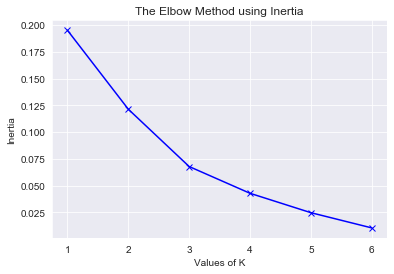

In [55]:
# plt.figure(figsize=(20,10))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

#### We notice the elbow profile at k = 3, and we select this value

In [59]:
# set the number of clusters
kclusters = 3

# amsterdam_grouped_clustering = amsterdam_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=50, max_iter=600, tol=0.0001, random_state=0)

kmeans.fit(amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([1, 0, 2, 1, 2, 2, 2])

#### Add clustering labels

In [57]:
# add clustering labels
boroughs_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

amsterdam_merged = amsdata_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
amsterdam_merged = amsterdam_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

amsterdam_merged.head() # check the last columns!

,Borough,Population,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Centrum,86422,52.369985,4.898014,1,Restaurant,French Restaurant,Italian Restaurant,Thai Restaurant,Mediterranean Restaurant,Chinese Restaurant,Seafood Restaurant,Lebanese Restaurant,Vietnamese Restaurant,American Restaurant
1,Noord,94766,52.391111,4.918306,2,Restaurant,Turkish Restaurant,Chinese Restaurant,Italian Restaurant,Asian Restaurant,Seafood Restaurant,Japanese Restaurant,Modern European Restaurant,Indonesian Restaurant,Vegetarian / Vegan Restaurant
2,Nieuw-West,151677,52.363742,4.806862,0,Turkish Restaurant,Restaurant,Chinese Restaurant,Fast Food Restaurant,Moroccan Restaurant,Indonesian Restaurant,Asian Restaurant,Falafel Restaurant,Cantonese Restaurant,Greek Restaurant
3,Oost,135767,52.352778,4.930556,1,Restaurant,Italian Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Thai Restaurant,Indonesian Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Indian Restaurant
4,West,143842,52.383025,4.852867,2,Restaurant,Italian Restaurant,Turkish Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Indonesian Restaurant,Seafood Restaurant,Caribbean Restaurant,Persian Restaurant,Middle Eastern Restaurant


### Create and display map of clusters

In [58]:
# create map
map_clusters = folium.Map(location=[ams_latitude, ams_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(amsterdam_merged['Latitude'], amsterdam_merged['Longitude'], amsterdam_merged['Borough'], amsterdam_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

for lat, lng, Borough, venue in zip(amsterdam_rest_df['Venue Lat'], amsterdam_rest_df['Venue Lng'], amsterdam_rest_df['Borough'], amsterdam_rest_df['Venue']):
    tag = '{}'.format(Borough)
    tag = folium.Popup(tag, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.5,
        popup=tag,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)
       
map_clusters

## Remarks and conclusions in preparation for the Report

####  We have used the following data: 
* 1. Baseline information of Amsterdam Boroughs and geo-location and demographics from Amsterdam Open Data 
* 2. The Foursquare API to retrieve specific Venue information filtered on Restaurant location

#### Analysis performed based on data sets
* 1. We explored and visualized the initial venue data retrieved using Foursquare API and noticed there are quite a few of non-Restaurant types included (Bakery, Snack-Bar, Fast Food, etc.)
* 2. We have filtered again the Venue Category data data to retain only 'Restaurant" object types
* 3. We obsevred that Nieuw-West has less frequency in Restaurants class

#### We have used K means to perform clustering, and we not that Nieuw-West has it's own cluster formed

#### By comparing the resulted data (figures, plots, maps) we conclude two areas are recomended for the new restaurant
* 1. **Amsterdam Nieuw-West** which has a category type Restaurant (only) **mean 15%** and has a population of 151677
* 2. **Amsterdam Oost** that comes second in place with a category type Restaurant (only) **mean 21%** and a population of 135767